In [2]:
# https://github.com/crmaximo/VAEGAN/blob/master/VAEGAN.py
# SETUP
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from keras.models import model_from_json

# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    #tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [3]:
# CREATE A SAMPLING LAYER
IMG_SHAPE = (256,256,1)
latent_dim = 32

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
#Input 
encoder_inputs = layers.Input(shape=IMG_SHAPE)
#Encoder 

y = layers.BatchNormalization()(encoder_inputs)

y = layers.Conv2D(16, (4, 4), padding='same',strides =(2,2))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(16, (4, 4), padding='same',strides =(1,1))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(32, (4, 4), padding='same',strides =(2,2))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(32, (4, 4), padding='same',strides =(1,1))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(64, (4, 4), padding='same',strides =(2,2))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(64, (4, 4), padding='same',strides =(1,1))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(128, (4, 4), padding='same',strides =(2,2))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(128, (4, 4), padding='same',strides =(1,1))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(256, (4, 4), padding='same',strides =(2,2))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

y = layers.Conv2D(256, (4, 4), padding='same',strides =(1,1))(y)
y = layers.BatchNormalization()(y)
y = layers.LeakyReLU(0.2)(y)

#Flattening for the bottleneck
vol = y.shape
y = layers.Flatten()(y)

z_mean = layers.Dense(latent_dim, name="z_mean")(y)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(y)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

2022-07-29 11:42:02.932186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-29 11:42:02.932230: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 11:42:02.932265: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Parula): /proc/driver/nvidia/version does not exist
2022-07-29 11:42:02.932922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  272         ['batch_normalization[0][0]']    
                                )                                                           

 flatten (Flatten)              (None, 16384)        0           ['leaky_re_lu_9[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 32)           524320      ['flatten[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 32)           524320      ['flatten[0][0]']                
                                                                                                  
 sampling (Sampling)            (None, 32)           0           ['z_mean[0][0]',                 
                                                                  'z_log_var[0][0]']              
                                                                                                  
Total params: 3,146,916
Trainable params: 3,144,930
Non-trainable params: 1,986
_____________________________

In [8]:

def res_block(n_filt, layer):
    d = layers.Conv2D(filters=n_filt, kernel_size=4, strides=1, padding='same')(layer)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(0.2)(d)
    d = layers.Add()([d, layer])
    return d

#Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(np.prod(vol[1:]), activation='relu')(latent_inputs)
x = layers.Reshape((vol[1], vol[2], vol[3]))(x)


x = layers.Conv2DTranspose(256, (4, 4), padding='same',strides =(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = res_block(256, x)

x = layers.Conv2DTranspose(128, (4, 4), padding='same',strides =(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = res_block(128, x)

x = layers.Conv2DTranspose(64, (4, 4), padding='same',strides =(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = res_block(64, x)

x = layers.Conv2DTranspose(32, (4, 4), padding='same',strides =(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = res_block(32, x)

x = layers.Conv2DTranspose(16, (4, 4), padding='same',strides =(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x1 = x
for i in range(5):
  x = res_block(16, x)

"""x = layers.concatenate([x1,x])"""

decoded = layers.Conv2DTranspose(1, (4,4), activation='sigmoid', padding='same')(x)

decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 16384)        540672      ['input_5[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 8, 8, 256)    0           ['dense_1[0][0]']                
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 16, 16, 256)  1048832    ['reshape_1[0][0]']              
 spose)                                                                                     

                                                                                                  
 conv2d_transpose_10 (Conv2DTra  (None, 256, 256, 16  8208       ['add_12[0][0]']                 
 nspose)                        )                                                                 
                                                                                                  
 batch_normalization_55 (BatchN  (None, 256, 256, 16  64         ['conv2d_transpose_10[0][0]']    
 ormalization)                  )                                                                 
                                                                                                  
 leaky_re_lu_52 (LeakyReLU)     (None, 256, 256, 16  0           ['batch_normalization_55[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_43

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 75 * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Loaded:  (80, 256, 256, 1)
Saved dataset:  immagini_256.npz
Loaded:  (80, 256, 256, 1)


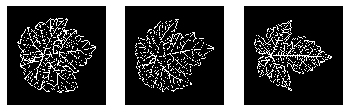

In [7]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
    src_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in sorted(listdir(path)):
        if filename == '.DS_Store':
            pass
        else:
            # load and resize the image
            pixels = load_img(path + '/' + filename, color_mode = 'grayscale', target_size=size) 
            # convert to numpy array
            pixels = img_to_array(pixels)
            # split into satellite and map
            sat_img = pixels
            src_list.append(sat_img)

    return [asarray(src_list)]
 
# dataset path
path = 'binVEINS256'
# load dataset
[src_images] = load_images(path)
print('Loaded: ', src_images.shape)
# save as compressed numpy array
filename = 'immagini_256.npz'
savez_compressed(filename, src_images)
print('Saved dataset: ', filename)

# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('immagini_256.npz')
train_images = data['arr_0']
print('Loaded: ', train_images.shape)

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = (train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32") )/255.

# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(train_images[i].astype('float32').squeeze(), cmap = 'gray')

(240, 256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

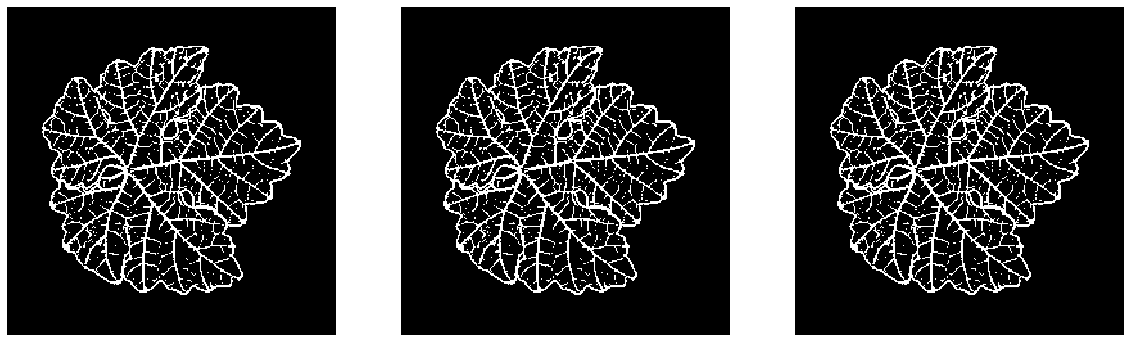

In [9]:
#DATA AUGMENTATION

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.125,  fill_mode='nearest', interpolation='bilinear'),
  keras.layers.experimental.preprocessing.RandomZoom(0.2, None, fill_mode='nearest', interpolation='bilinear')
                                    ])
aug_train = train_images
for i in range(2):
    aug_data = data_augmentation(train_images)
    aug_train = tf.concat([aug_train, aug_data], axis=0).numpy()
print(aug_train.shape)
del aug_data

fig, axs = pyplot.subplots(1,3, figsize=(20,20))

axs[0].imshow(aug_train[0].squeeze(), cmap="Greys_r")
axs[0].axis('Off')
axs[1].imshow(aug_train[80].squeeze(), cmap="Greys_r")
axs[1].axis('Off')
axs[2].imshow(aug_train[160].squeeze(), cmap="Greys_r")
axs[2].axis('Off')


In [8]:
vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001))                  

vae.fit(aug_train, epochs=2000, batch_size=64)


Epoch 1/100
120/120 [==============================] - 109s 893ms/step - loss: 28913.9870 - reconstruction_loss: 18404.7363 - kl_loss: 23.0531
Epoch 2/100
115/120 [===========================>..] - ETA: 4s - loss: 12395.9561 - reconstruction_loss: 12709.7637 - kl_loss: 3.4783

KeyboardInterrupt: 

In [ ]:
# serialize model to JSON
encoder_json = encoder.to_json()
with open("encoder.json", "w") as json_file:              
    json_file.write(encoder_json)
# serialize weights to HDF5
encoder.save_weights("Results/encoder.h5")

decoder_json = decoder.to_json()
with open("Results/decoder.json", "w") as json_file:
    json_file.write(decoder_json)
    
# serialize weights to HDF5
decoder.save_weights("Results/decoder.h5")
print("Saved model to disk")

In [10]:
# load json and create model
json_file = open('Results/decoder.json', 'r')
loaded_decoder_json = json_file.read()
json_file.close()
loaded_decoder = model_from_json(loaded_decoder_json)

json_file = open('Results/encoder.json', 'r')
loaded_encoder_json = json_file.read()
json_file.close()
loaded_encoder = model_from_json(loaded_encoder_json,custom_objects ={'Sampling':Sampling})

# load weights into new model
#loaded_encoder = keras.models.load_model('/content/drive/My Drive/pix2pix/train_data/Copia di encoder_provaaa2.h5',custom_objects ={'Sampling':Sampling} )
loaded_encoder.load_weights("Results/encoder.h5")
loaded_decoder.load_weights("Results/decoder.h5")

print("Loaded model from disk")

Loaded model from disk


1/1 [==============================] - 0s 449ms/step


(-0.5, 255.5, 255.5, -0.5)

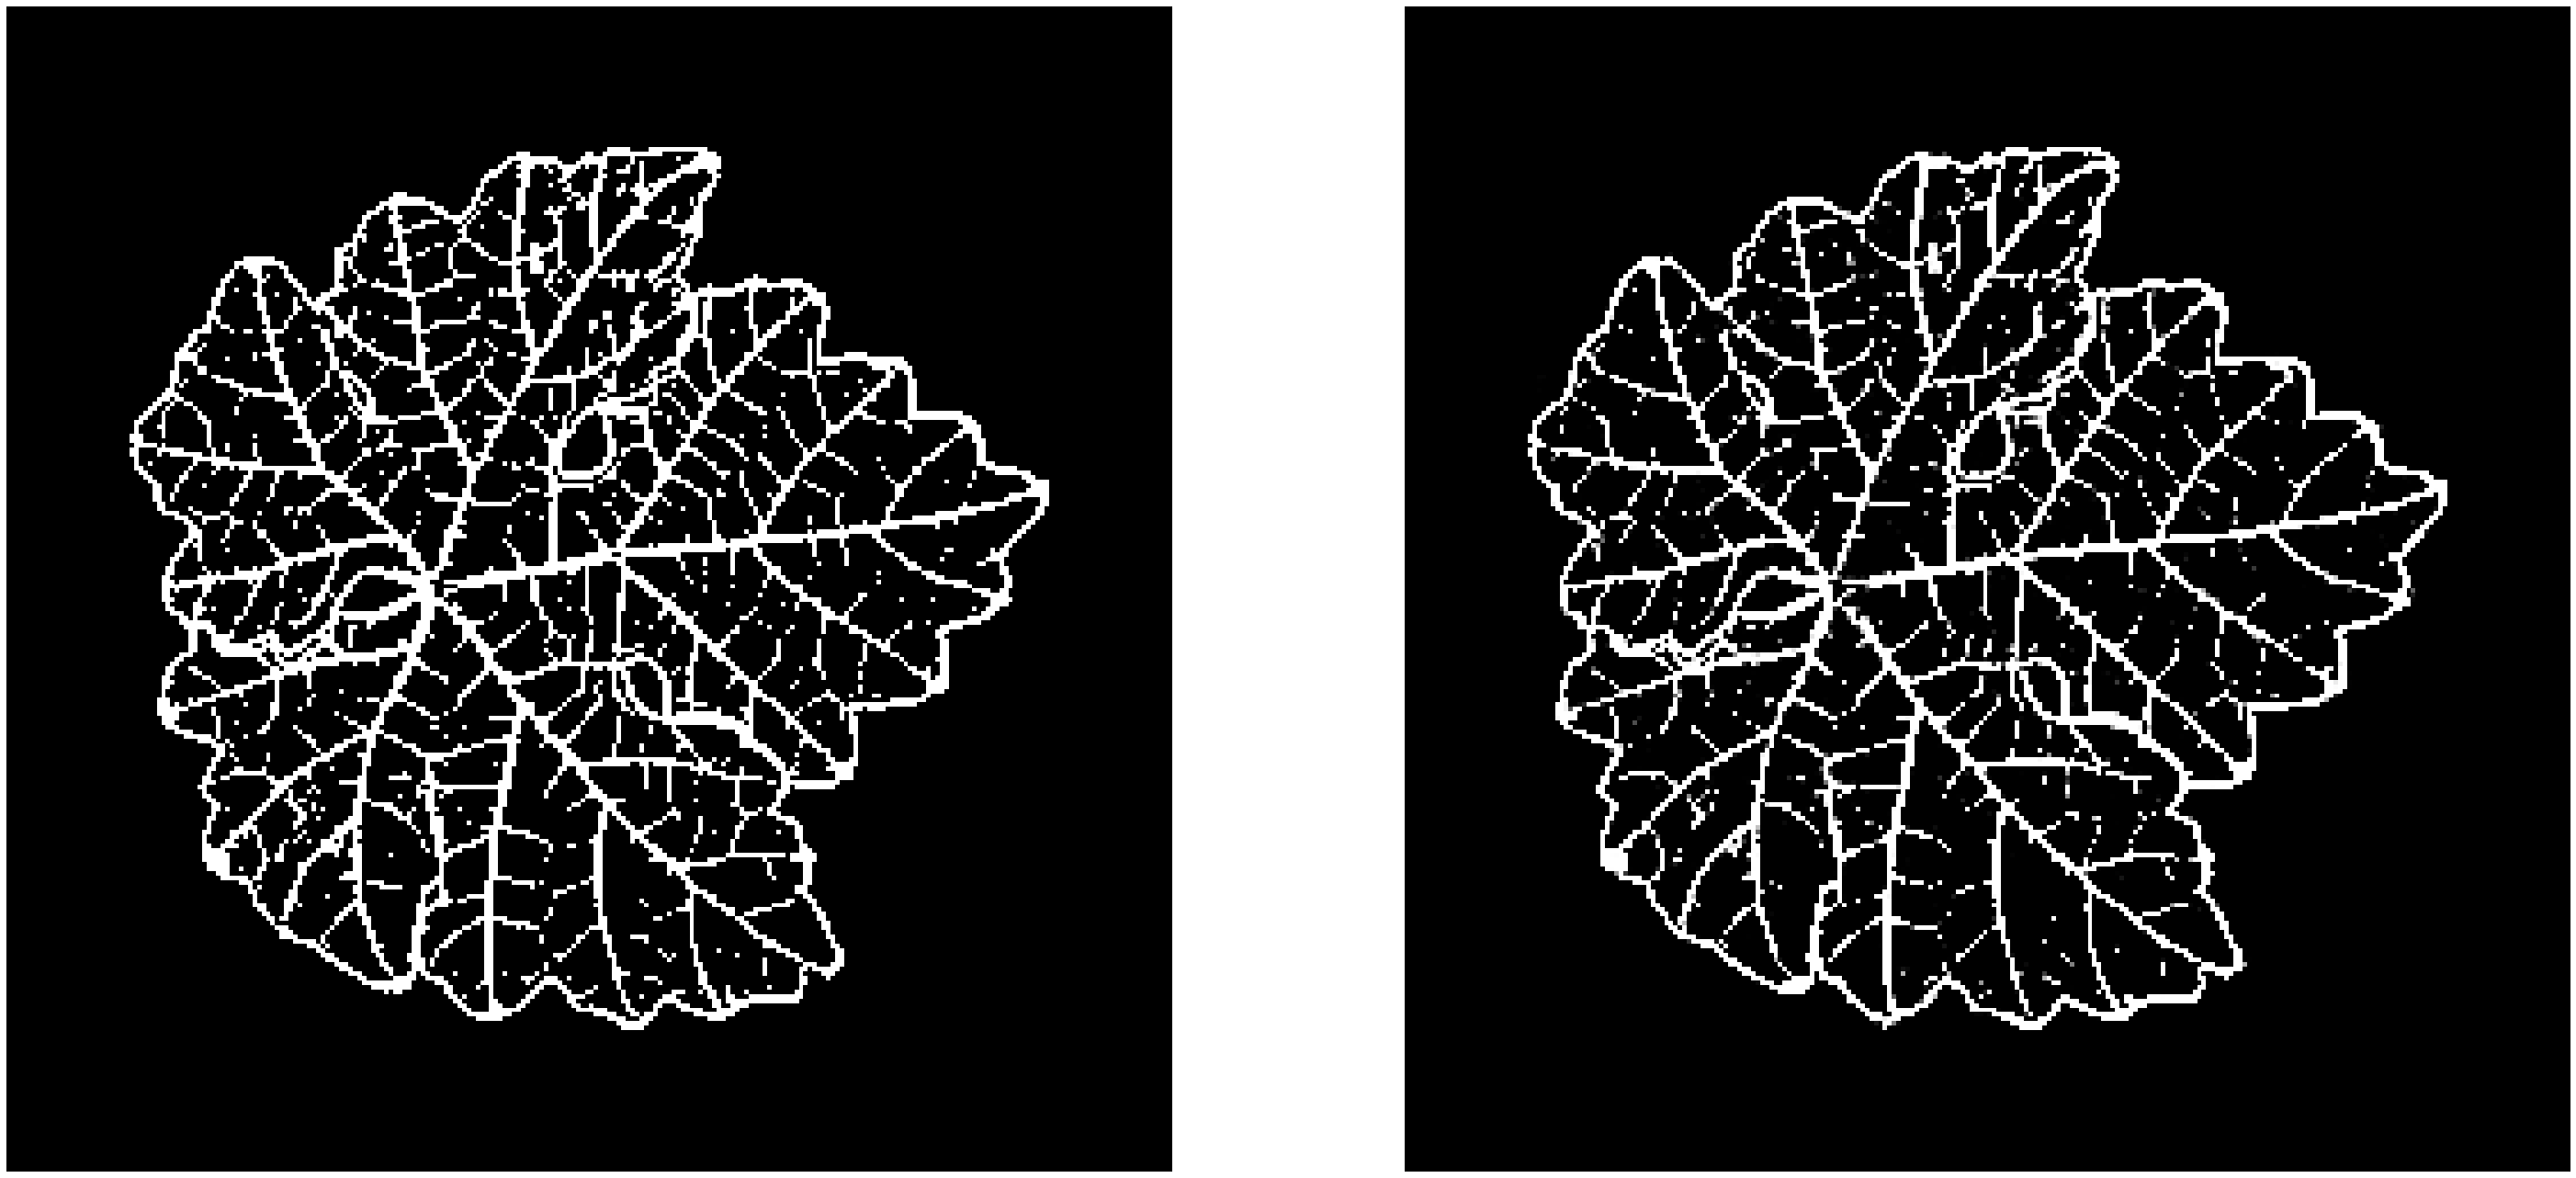

In [11]:
# Encode and decode some images
encoded_imgs = loaded_encoder.predict(train_images[0:1])
decoded_imgs = loaded_decoder.predict(encoded_imgs[2])

fig, axs = pyplot.subplots(1,2, figsize=(50,50))

axs[0].imshow(train_images[0].squeeze(), cmap="Greys_r") 
axs[0].axis('Off')
axs[1].imshow(decoded_imgs[0].squeeze(), cmap="Greys_r")
axs[1].axis('Off')


1/1 [==============================] - 0s 103ms/step


(-0.5, 255.5, 255.5, -0.5)

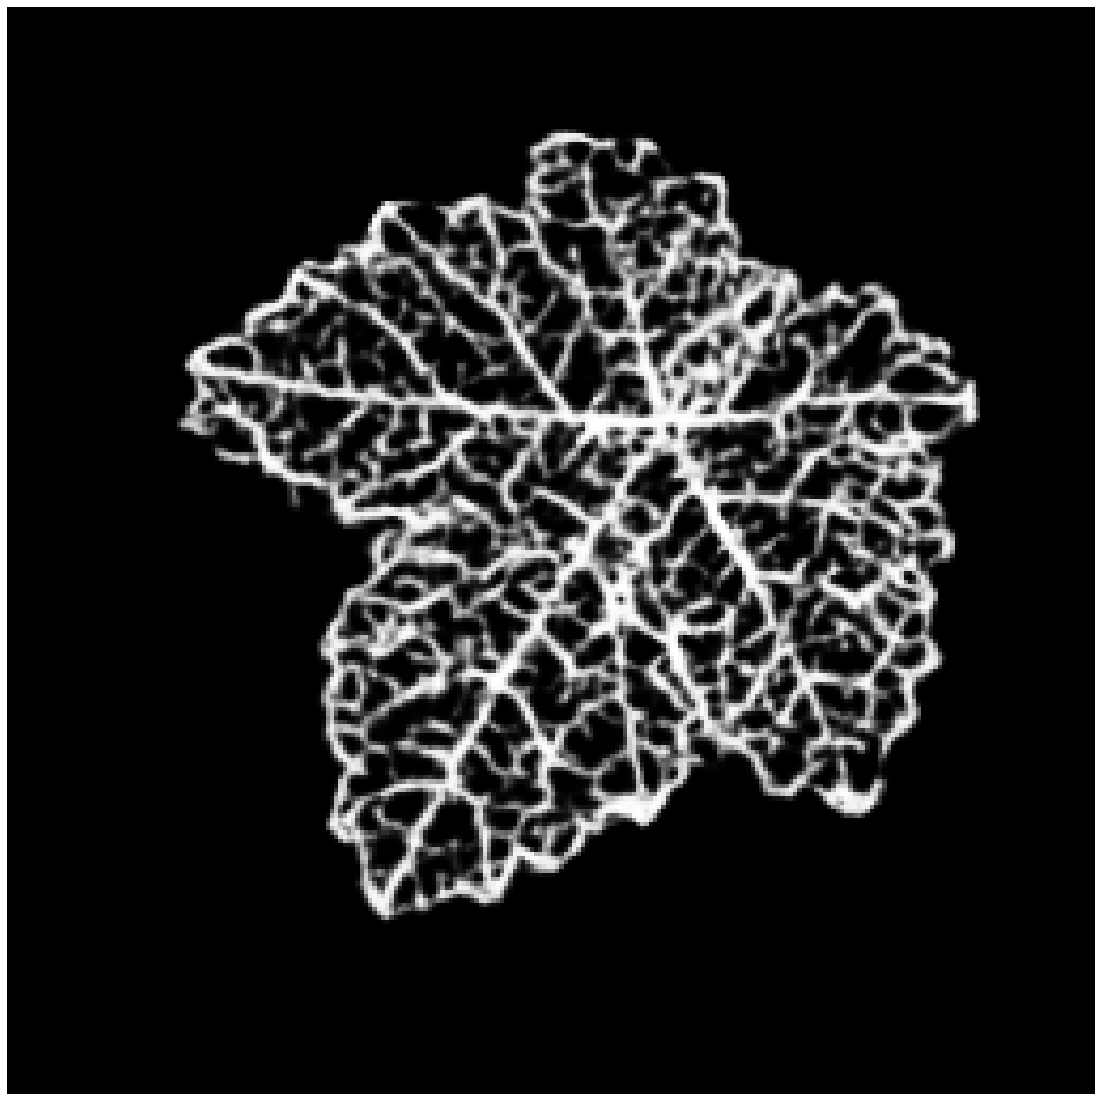

In [22]:
to_build = tf.random.normal(shape = [1, latent_dim])
generated = loaded_decoder.predict(to_build)

fig = pyplot.figure(figsize=(20, 20))
pyplot.imshow(generated[0].squeeze(), cmap="Greys_r")
pyplot.axis('Off')
